<h2>Import</h2>

In [1]:
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage import measure
from skimage.filters import threshold_otsu
from skimage.measure import regionprops
import matplotlib.patches as patches
import numpy as np
from skimage.transform import resize
from PIL import Image

<h2>Setup and Variables</h2>

In [2]:
images_dir = 'images/'
labels_dir = 'labels/'

In [3]:
image_name = '0d877fcf8137cfc5'
image = images_dir + image_name + '.jpg'
label = labels_dir + image_name + '.txt'

<h2>View Image</h2>


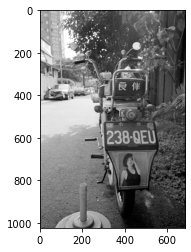

In [4]:
image = imread(image, as_gray=True)
fig, ax1 = plt.subplots(1)
ax1.imshow(image, cmap="gray")
plt.show()

<h2>Isolate Image</h2>

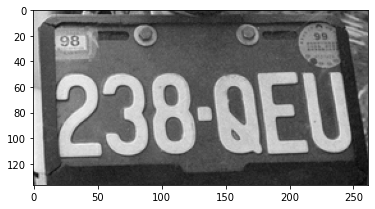

In [5]:
# Read labels
f = open(label, "r")
text = f.read()
# Isolate coordinates
text = text[2:]

#relative x-center, relative y-center, width, height 
coords = text.split()

rel_x_center = float(coords[0])
rel_y_center = float(coords[1])
rel_width = float(coords[2])
rel_height = float(coords[3])

# Get image dimensions
image_height = image.shape[0]
image_width = image.shape[1]

#Convert relative values [0, 1] to defined pixel positions
plate_center_x = image_width * rel_x_center
plate_center_y = image_height * rel_y_center
plate_width = image_width * rel_width
plate_height = image_height * rel_height

x_offset = plate_width / 2
y_offset = plate_height / 2

#Get plate coordinates
x_min = int(plate_center_x - x_offset)
x_max = int(plate_center_x + x_offset)

y_min = int(plate_center_y - y_offset)
y_max = int(plate_center_y + y_offset)

cropped_image = image[y_min:y_max, x_min:x_max]

fig, ax1 = plt.subplots(1)
ax1.imshow(cropped_image, cmap="gray")
plt.show()

<h2>Convert to Binary</h2>

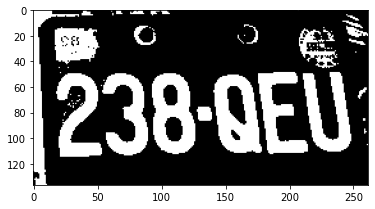

In [6]:
# Define threshold for maximizing variance
threshold_value = threshold_otsu(cropped_image)

# Show binary (thresholded) version of image
binary_image = cropped_image > threshold_value

fig, ax1 = plt.subplots(1)
ax1.imshow(binary_image, cmap="gray")
plt.show()

Don't invert


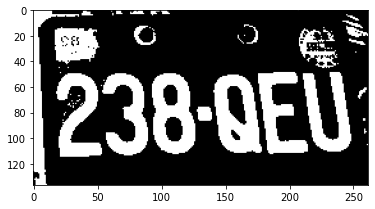

In [7]:
# Determine if inversion is necessary to standardize plates

# Count the number of white (1) and black (0) pixels
white_pixels = np.sum(binary_image)  # Sum of 1s
black_pixels = binary_image.size - white_pixels  # Total pixels - white pixels

# If there are more white pixels than black, assume black text on white background
if white_pixels > black_pixels:
    print("Invert")
    #Invert
    updated_plate = np.invert(binary_image)
else:
    updated_plate = binary_image
    print("Don't invert")

# Display updated plate
fig, ax1 = plt.subplots(1)
ax1.imshow(updated_plate, cmap="gray")
plt.show()

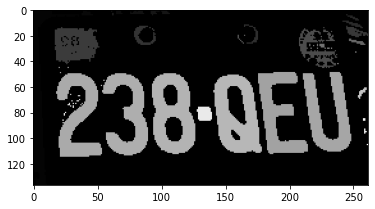

In [8]:
# Label connected regions
labeled_plate = measure.label(updated_plate)

# Display labeled plate
fig, ax1 = plt.subplots(1)
ax1.imshow(labeled_plate, cmap="gray")
plt.show()

In [9]:
# Define constraints - each corresponds to relative percentage (ex. 10% of image width)
MIN_REL_LP_HEIGHT = 0.15
MAX_REL_LP_HEIGHT = 0.80
MIN_REL_LP_WIDTH = 0.04
MAX_REL_LP_WIDTH = 0.30

# Define constraint variables
min_char_height = plate_height * MIN_REL_LP_HEIGHT
max_char_height = plate_height * MAX_REL_LP_HEIGHT
min_char_width = plate_width * MIN_REL_LP_WIDTH
max_char_width = plate_width * MAX_REL_LP_WIDTH

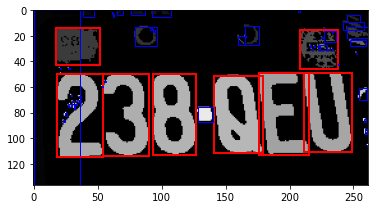

In [10]:
# Store recognized characters
characters = []
char_data = []

# Create image
fig, ax1 = plt.subplots(1)
ax1.imshow(labeled_plate, cmap="gray")

# Get regions within the license plate
for regions in regionprops(labeled_plate):
    # Define region boundary coordinates
    y0, x0, y1, x1 = regions.bbox
    region_height = y1 - y0
    region_width = x1 - x0
    
    # Check if region meets contraints (possible characters)
    if (
        region_height > min_char_height and
        region_height < max_char_height and
        region_width > min_char_width and
        region_width < max_char_width
    ):
        # Define region and outline
        roi = updated_plate[y0:y1, x0:x1]
        rect_border = patches.Rectangle((x0, y0), x1-x0, y1-y0, edgecolor="red", linewidth=2, fill=False)
        ax1.add_patch(rect_border)
        
        # Resize and append to array
        resized_char = resize(roi, (20, 20))
        characters.append(resized_char)
        
        # Store area for later filtering and x0 for unique ID
        char_area = region_height * region_width
        char_data.append((char_area, x0))
        
    else:
        # Distinguish non-candidate regions
        rect_border = patches.Rectangle((x0, y0), x1-x0, y1-y0, edgecolor="blue", linewidth=1, fill=False)
        ax1.add_patch(rect_border)
        
        
plt.show()

In [11]:
# Get median area and limit size variance for characters to prevent wrongly-sized candidates from being included

# Create array of just areas (tuple 0)
char_areas = np.array([t[0] for t in char_data])
# Get median of areas
area_median = np.median(char_areas)

# Set parameters
minus_allowed = .10
plus_allowed = .15
max_allowed = area_median * (1 + plus_allowed)
min_allowed = area_median * (1 - minus_allowed)

# Print summary statistics
print("Areas:", char_areas)
print("Median:", area_median)
print("Allowed Range:", min_allowed, "-", max_allowed, '\n')
        
# Create placeholder array
filtered_characters = []

# Filter both char_data and characters together by mapping with zip
for candidate, character in zip(char_data, characters):
    candidate_area = candidate[0]
    if min_allowed < candidate_area < max_allowed:
        print(candidate_area, "\tAllowed")
        filtered_characters.append(character)
    else:
        print(candidate_area, "\tExcluded")

Areas: [1015  930 2496 2356 2340 2304 2142 2318]
Median: 2311.0
Allowed Range: 2079.9 - 2657.6499999999996 

1015 	Excluded
930 	Excluded
2496 	Allowed
2356 	Allowed
2340 	Allowed
2304 	Allowed
2142 	Allowed
2318 	Allowed


In [12]:
# Remove non-character candidates by only getting 6 best matches

print(characters[6])

#for character in enumerate(characters):
    #print(character)

[[0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0.]
 [0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0.]
 [0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
 [0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0.]
 [0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
 [0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0.]
 [0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.

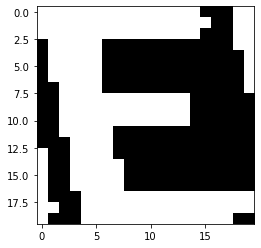

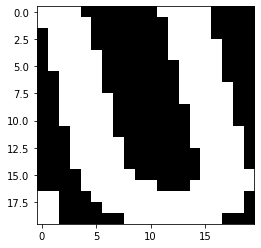

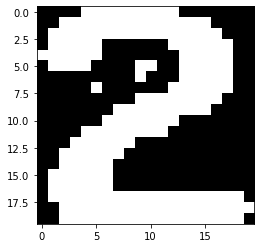

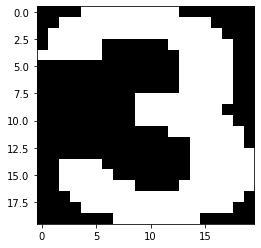

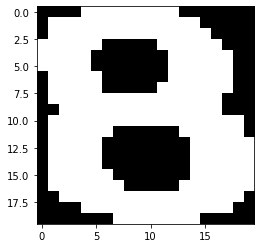

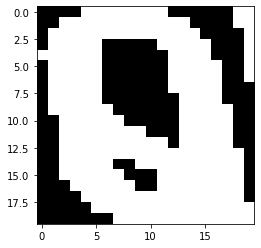

In [13]:
for i, character in enumerate(filtered_characters):
    fig, ax1 = plt.subplots(1)
    ax1.imshow(character, cmap="gray")

In [14]:
for i, character in enumerate(filtered_characters):
    # Convert to PIL image
    img = Image.fromarray(characters[i].astype(np.uint8) * 255)  # Scale to 0 and 255 for black and white

    # Save as PNG
    img.save('exported_characters/' + str(i) + '_' + image_name + '.png')